# Part 2: Data Analysis

## Step 1: Install necessary modules

In [2]:
pip install numpy pandas matplotlib 

Note: you may need to restart the kernel to use updated packages.


## Step 2: Build Functions

### 2.1 Import modules

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2.2 Data extraction

In [2]:
# Input: .csv files containing the raw data directly downloaded from pavlovia.org
# Output: Dataframe file with selected items for all participants 
def Data2Df(categoryList):    
    dfRaw = pd.DataFrame()
    
    for category in categoryList:
        directory = category + "/data/"

        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    dfParticipant = pd.read_csv(directory + file)
                
                    # add category column
                    dfParticipant['category'] = category             
                    dfRaw = dfRaw.append(dfParticipant)
                    
    # filter out useful information from raw data
    df = dfRaw[['key_resp_2.keys', 
                'key_resp_2.rt', 
                'image_left', 
                'image_right', 
                'trial_num', 
                'participant', 
                'date',
                'category']]
    
    # change column name to better organize data
    df = df.rename(columns={'key_resp_2.keys': 'score', 'key_resp_2.rt': 'time'})
    
    # Disable warning due to potential 'chained' assignments in Dataframe
    pd.options.mode.chained_assignment = None 
    df['score'] = df['score'].replace(['z', 'm'],[1, 0])
    
    return df

### 2.3 Dataframe group

In [3]:
def groupbyItem(df, item):
    dfItem = df.groupby(item).mean()
    dfItem = dfItem[['score', 'time']]
    dfItem.reset_index(inplace=True)
    
    return dfItem

## Step 3: Preliminary Visualization

### 3.1 Plots

/Users/loni/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


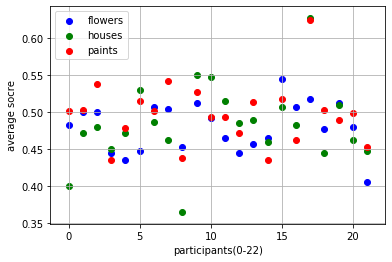

In [4]:
# Plot the average score of the 22 participants
# Note: 1. this is the result for all 3 categories
#       2. for each image pair, the participant gets 1 score if he/she select 
#          the left image, and 0 score if he/she select the right image

# flowers
categories = ['flowers']
df = Data2Df(categories)
fDf = groupbyItem(df, 'participant')
x1 = fDf.index.to_numpy()
y1 = fDf.score.to_numpy()
z1 = fDf.time.to_numpy()

# houses
categories = ['houses']
df = Data2Df(categories)
hDf = groupbyItem(df, 'participant')
x2 = hDf.index.to_numpy()
y2 = hDf.score.to_numpy()
z2 = hDf.time.to_numpy()

# paints
categories = ['paints']
df = Data2Df(categories)
pDf = groupbyItem(df, 'participant')
x3 = pDf.index.to_numpy()
y3 = pDf.score.to_numpy()
z3 = pDf.time.to_numpy()


plt.scatter(x1, y1, c='b', label = 'flowers')
plt.scatter(x2, y2, c='g', label = 'houses')
plt.scatter(x3, y3, c='r', label = 'paints')

plt.xlabel('participants(0-22)')
plt.ylabel('average socre')
plt.legend()
plt.grid()
plt.show()

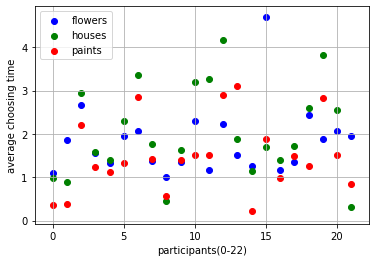

In [5]:
plt.scatter(x1, z1, c='b', label = 'flowers')
plt.scatter(x2, z2, c='g', label = 'houses')
plt.scatter(x3, z3, c='r', label = 'paints')

plt.xlabel('participants(0-22)')
plt.ylabel('average choosing time')
plt.legend()
plt.grid()
plt.show()

### 3.2 Correlation analysis

In [7]:
categories = ['flowers','houses','paints']
df = Data2Df(categories)
participantDf = groupbyItem(df, 'participant')
participantDf.corr(method = 'kendall')

,score,time
score,1.000000,0.329719
time,0.329719,1.000000


In [8]:
df

,score,time,image_left,image_right,trial_num,participant,date,category
0,1,5.310000,flowers/images/125.jpg,flowers/images/165.jpg,1,Ai,2020-11-21_22h07.13.545,flowers
1,0,4.539000,flowers/images/168.jpg,flowers/images/195.jpg,2,Ai,2020-11-21_22h07.13.545,flowers
2,1,1.846000,flowers/images/114.jpg,flowers/images/131.jpg,3,Ai,2020-11-21_22h07.13.545,flowers
3,1,1.767000,flowers/images/110.jpg,flowers/images/241.jpg,4,Ai,2020-11-21_22h07.13.545,flowers
4,1,2.042000,flowers/images/157.jpg,flowers/images/170.jpg,5,Ai,2020-11-21_22h07.13.545,flowers
...,...,...,...,...,...,...,...,...
406,1,3.173355,paints/images/236.jpg,paints/images/369.jpg,207,Anran Luo,2020-11-22_14h53.35.645,paints
407,0,2.791595,paints/images/219.jpg,paints/images/136.jpg,208,Anran Luo,2020-11-22_14h53.35.645,paints
408,0,0.991650,paints/images/306.jpg,paints/images/239.jpg,209,Anran Luo,2020-11-22_14h53.35.645,paints
409,1,1.056805,paints/images/108.jpg,paints/images/259.jpg,210,Anran Luo,2020-11-22_14h53.35.645,paints


## Step 4: Export label files for deep learning

In [9]:
# Input: Dataframe from the output of Data2Df function
# Output: Dataframe containing the score of each image
def Df2Score(df):
    # create score table for left image and right image, respectively
    # the current score is calculated with basic average score of each
    # image, more advanced math model can be applied to better differentiate 
    # the performance of each image.
    key = df['score']

    leftScore = key
    rightScore = key.replace([1,0], [0,1])

    # create image to score dataframe
    imageDir = list(df['image_left']) + list(df['image_right'])
    score = list(leftScore) + list(rightScore)
    dfScore = pd.DataFrame({'imageDir':imageDir, 'score':score})
    dfScore = dfScore.groupby('imageDir').mean()
    
    return dfScore

In [11]:
dfScore = Df2Score(df)
print(dfScore)
dfScore.to_csv('score.csv')

                           score
imageDir                        
flowers/images/0.jpg    0.363636
flowers/images/1.jpg    0.227273
flowers/images/10.jpg   0.431818
flowers/images/100.jpg  0.477273
flowers/images/101.jpg  0.454545
...                          ...
paints/images/95.jpg    0.363636
paints/images/96.jpg    0.500000
paints/images/97.jpg    0.568182
paints/images/98.jpg    0.613636
paints/images/99.jpg    0.477273

[1151 rows x 1 columns]
